In [48]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from sklearn.naive_bayes import GaussianNB
from category_encoders import BinaryEncoder ,OneHotEncoder
from sklearn.metrics import accuracy_score
from scipy import stats
from sklearn import preprocessing

The train and test data has no header.This makes it difficult to understand what features we are working with.Fortunately the the data description file contains details of the different features and we shall use that add our headers

In [2]:
train = pd.read_csv('data/adult.data',header = None,names =['age','workclass',
                                                            'fnlwgt','education','education-num',
                                                            'marital-status','occupation','relationship',
                                                           'race','sex','capital-gain',
                                                            'capital-loss','hours-per-week','native-country','y'])
test = pd.read_csv('data/adult.test',header = None,names =['age','workclass',
                                                            'fnlwgt','education','education-num',
                                                            'marital-status','occupation','relationship',
                                                           'race','sex','capital-gain',
                                                            'capital-loss','hours-per-week','native-country','y'])

print(train.shape)
print(test.shape)

(32561, 15)
(16282, 15)


# Exploratory Data Analysis (EDA)



It looks like we have columns that have nominal and categorical values.
In a nominal categorical data attribute, there is no sense of ordering among the values of that attribute.
Ex. In our case ,if we look at the 'occupation' attribute we notice that there cannot be any ordering between it's values. An 'Exec-managerial' does not have an higher value (if it has any value ) than a 'Prof-specialty'

Remove all rows with NaN values from both train and test sets

In [3]:
test=test.dropna()
train = train.dropna()

Before we try to understand on how to handle categorical or numerical data for our predictive model, let us look at the distribution of train data

workclass
 ?                    1836
 Federal-gov           960
 Local-gov            2093
 Never-worked            7
 Private             22696
 Self-emp-inc         1116
 Self-emp-not-inc     2541
 State-gov            1298
 Without-pay            14
dtype: int64


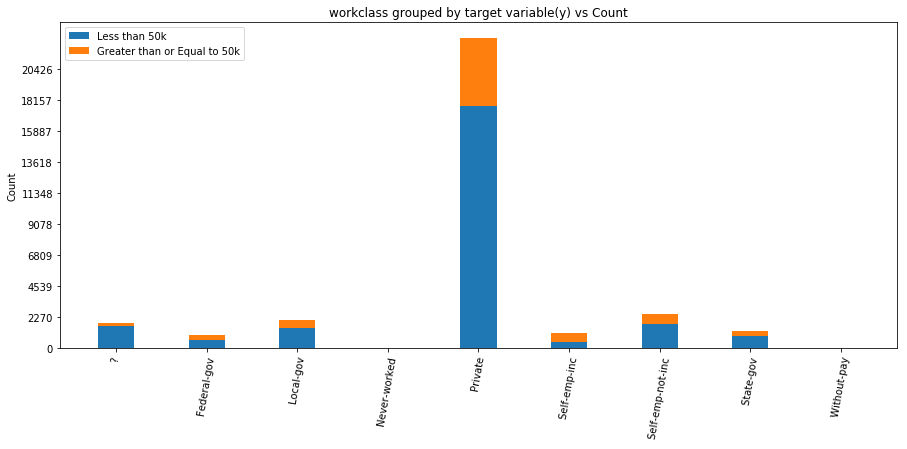

education
 10th              933
 11th             1175
 12th              433
 1st-4th           168
 5th-6th           333
 7th-8th           646
 9th               514
 Assoc-acdm       1067
 Assoc-voc        1382
 Bachelors        5355
 Doctorate         413
 HS-grad         10501
 Masters          1723
 Preschool          51
 Prof-school       576
 Some-college     7291
dtype: int64


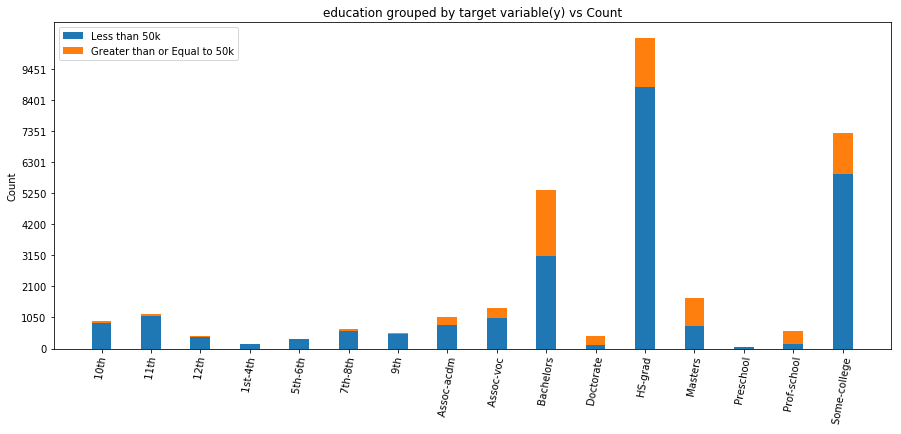

marital-status
 Divorced                  4443
 Married-AF-spouse           23
 Married-civ-spouse       14976
 Married-spouse-absent      418
 Never-married            10683
 Separated                 1025
 Widowed                    993
dtype: int64


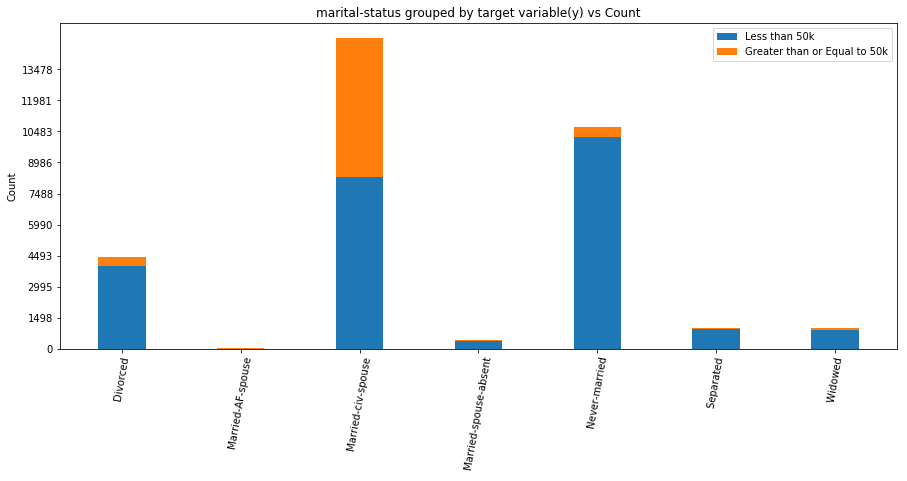

occupation
 ?                    1843
 Adm-clerical         3770
 Armed-Forces            9
 Craft-repair         4099
 Exec-managerial      4066
 Farming-fishing       994
 Handlers-cleaners    1370
 Machine-op-inspct    2002
 Other-service        3295
 Priv-house-serv       149
 Prof-specialty       4140
 Protective-serv       649
 Sales                3650
 Tech-support          928
 Transport-moving     1597
dtype: int64


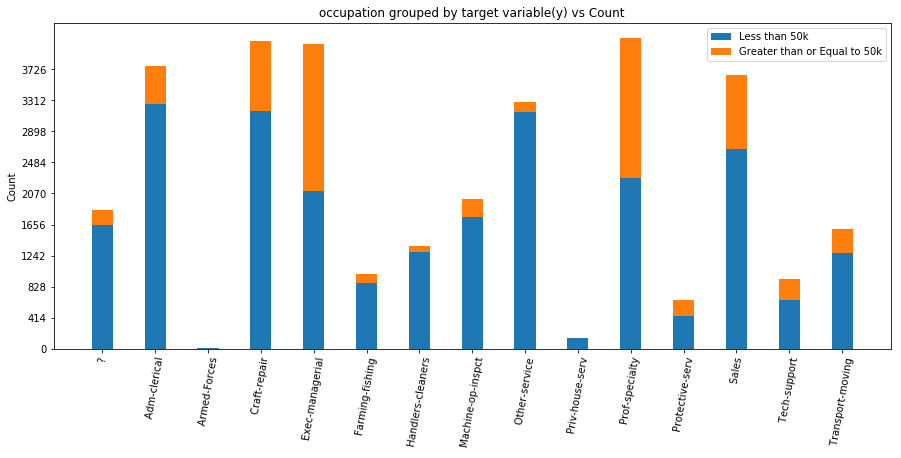

relationship
 Husband           13193
 Not-in-family      8305
 Other-relative      981
 Own-child          5068
 Unmarried          3446
 Wife               1568
dtype: int64


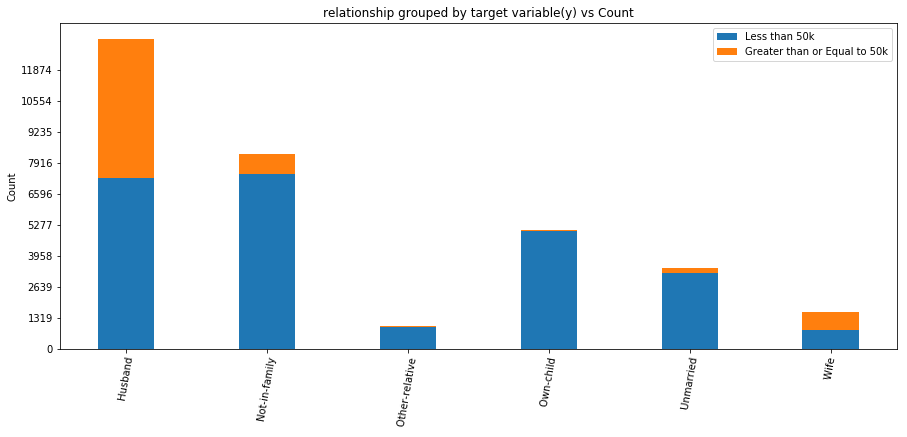

race
 Amer-Indian-Eskimo      311
 Asian-Pac-Islander     1039
 Black                  3124
 Other                   271
 White                 27816
dtype: int64


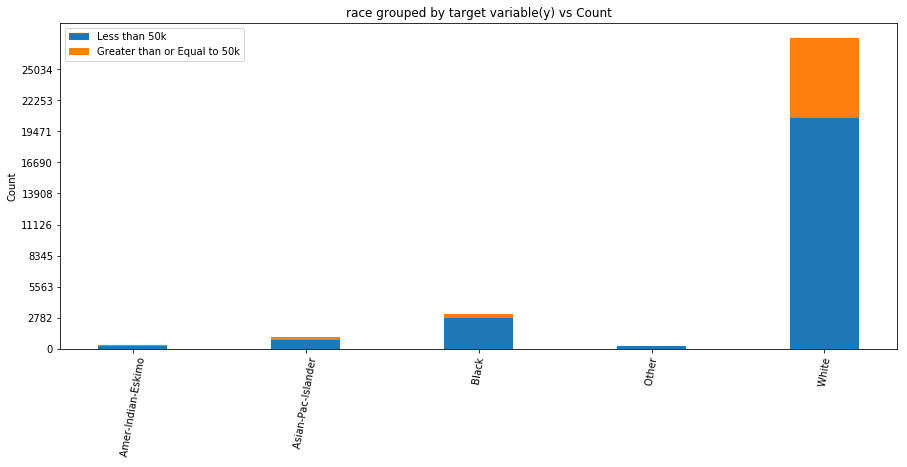

sex
 Female    10771
 Male      21790
dtype: int64


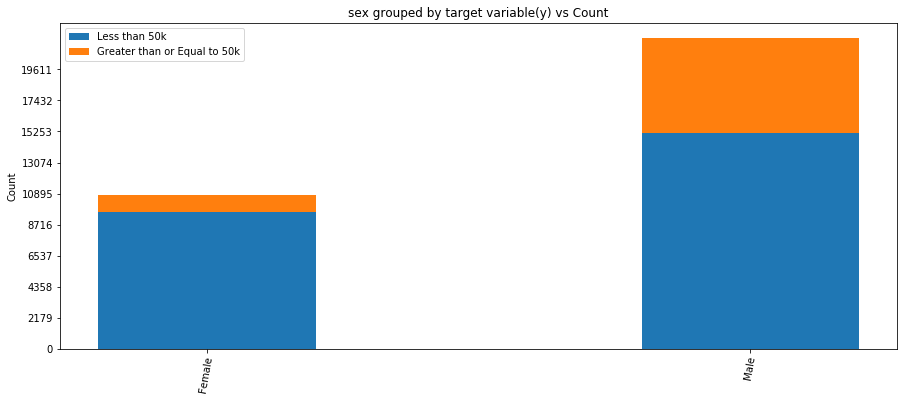

native-country
 ?                               583
 Cambodia                         19
 Canada                          121
 China                            75
 Columbia                         59
 Cuba                             95
 Dominican-Republic               70
 Ecuador                          28
 El-Salvador                     106
 England                          90
 France                           29
 Germany                         137
 Greece                           29
 Guatemala                        64
 Haiti                            44
 Holand-Netherlands                1
 Honduras                         13
 Hong                             20
 Hungary                          13
 India                           100
 Iran                             43
 Ireland                          24
 Italy                            73
 Jamaica                          81
 Japan                            62
 Laos                             18
 Mexico                

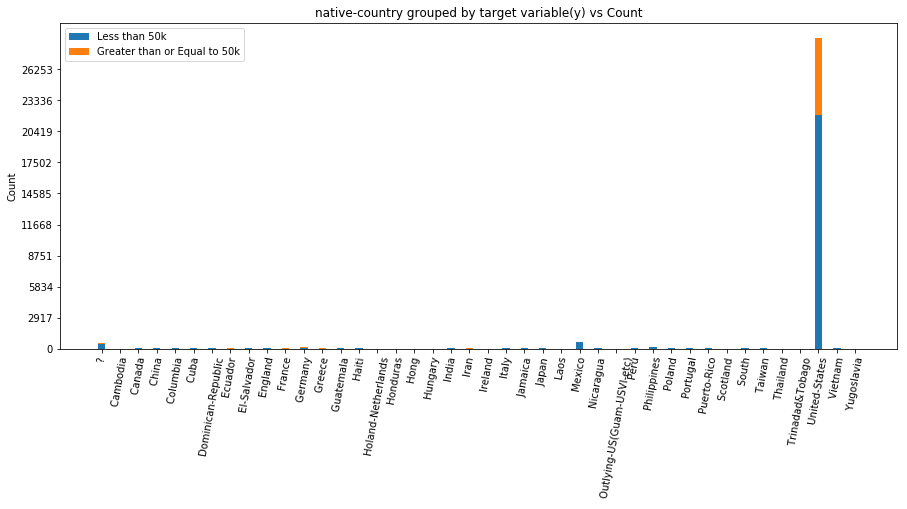

In [67]:
#train['marital-status'].value_counts()
category_columns =['workclass','education','marital-status','occupation','relationship','race','sex','native-country']
fig_size = plt.rcParams["figure.figsize"]

fig_size[0] = 15
fig_size[1] = 6
plt.rcParams["figure.figsize"] = fig_size
for i in category_columns:
    category =train[i].value_counts()
    N=category.count()
    print(train.groupby(i).size())
    column = train.groupby(i).size().keys()
    #print(column)
    less50df= pd.DataFrame(0, index=np.arange(1), columns=column)
    greater50df= pd.DataFrame(0, index=np.arange(1), columns=column)
    
    for j in column:
        less50df.at[0,j]    = train[train['y']==' <=50K'].groupby(i).size().get(j)
        greater50df.at[0,j] = train[train['y']==' >50K'].groupby(i).size().get(j)
    
    less50 =  list(less50df.iloc[0])
    greater50 = list(greater50df.iloc[0])
    #print(less50)
    #print(greater50)
    ind = np.arange(N)
    width = 0.4

    p1 = plt.bar(ind,less50,width)
    p2 = plt.bar(ind,greater50,width,bottom = less50)



    plt.ylabel('Count')
    plt.title(i+ ' grouped by target variable(y) vs Count')
    plt.xticks(ind,list(train.groupby(i).size().keys()),rotation=80)
    plt.yticks(np.arange(0, max(train.groupby(i).size() ), max(train.groupby(i).size() )/10))
    plt.legend((p1[0], p2[0]), ('Less than 50k', 'Greater than or Equal to 50k'))
    plt.show()

# Binary Encoding of categorical features

Categorical input cannot be plugged in to our predictive model as it is.It needs to encoded.
For a guide to encoding categorical features ,take a look at the below link

http://pbpython.com/categorical-encoding.html

Let us split the train and test set into input feature variable and target output

In [5]:
trainX = train.iloc[:,:14]
trainY = train.iloc[:,14:]
testX = test.iloc[:,:14]
testY = test.iloc[:,14:]

For the target variable replacement of ' <=50k' to 0 and ' >50k' to 1 would suffice as our goal is simple Binary classification

In [6]:
trainY_encoded = trainY.replace(' <=50K',0)
trainY_encoded = trainY_encoded.replace(' >50K',1)
testY_encoded = testY.replace(' <=50K.',0)
testY_encoded = testY_encoded.replace(' >50K.',1)

Now we use the library we imported to perform Binary encoding(We chose binary encoding over One hot encoding as ,one hot encoding increase the number of columns by a huge factor)

In [54]:
#encoder1 = OneHotEncoder(return_df = True)
#encoder2 = OneHotEncoder(return_df = True)

encoder1 = BinaryEncoder(return_df = True)
encoder2 = BinaryEncoder(return_df = True)

In [55]:
trainX_encoded = encoder1.fit_transform(trainX)
testX_encoded = encoder1.fit_transform(testX)

We can see the number of columns increased from 14 to 42 (If it was One Hot encoding the number of columns would be higher)

In [56]:
print(trainX.shape)
print(trainX_encoded.shape)
print(testX.shape)
print(testX_encoded.shape)

(32561, 14)
(32561, 42)
(16281, 14)
(16281, 42)


In [57]:
trainX_encoded.head(5)

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,education_0,education_1,education_2,education_3,education_4,...,native-country_3,native-country_4,native-country_5,native-country_6,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,39,77516,13,2174,0,40
1,0,0,0,1,0,0,0,0,0,1,...,0,0,0,1,50,83311,13,0,0,13
2,0,0,0,1,1,0,0,0,1,0,...,0,0,0,1,38,215646,9,0,0,40
3,0,0,0,1,1,0,0,0,1,1,...,0,0,0,1,53,234721,7,0,0,40
4,0,0,0,1,1,0,0,0,0,1,...,0,0,1,0,28,338409,13,0,0,40


In [58]:
testX_encoded.head(5)

,workclass_0,workclass_1,workclass_2,workclass_3,workclass_4,education_0,education_1,education_2,education_3,education_4,...,native-country_3,native-country_4,native-country_5,native-country_6,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
1,0,0,0,0,1,0,0,0,0,1,...,0,0,0,1,25,226802.0,7.0,0.0,0.0,40.0
2,0,0,0,0,1,0,0,0,1,0,...,0,0,0,1,38,89814.0,9.0,0.0,0.0,50.0
3,0,0,0,1,0,0,0,0,1,1,...,0,0,0,1,28,336951.0,12.0,0.0,0.0,40.0
4,0,0,0,0,1,0,0,1,0,0,...,0,0,0,1,44,160323.0,10.0,7688.0,0.0,40.0
5,0,0,0,1,1,0,0,1,0,0,...,0,0,0,1,18,103497.0,10.0,0.0,0.0,30.0


In [12]:
trainX_encoded.columns

Index(['workclass_0', 'workclass_1', 'workclass_2', 'workclass_3',
       'workclass_4', 'education_0', 'education_1', 'education_2',
       'education_3', 'education_4', 'marital-status_0', 'marital-status_1',
       'marital-status_2', 'marital-status_3', 'occupation_0', 'occupation_1',
       'occupation_2', 'occupation_3', 'occupation_4', 'relationship_0',
       'relationship_1', 'relationship_2', 'relationship_3', 'race_0',
       'race_1', 'race_2', 'race_3', 'sex_0', 'sex_1', 'native-country_0',
       'native-country_1', 'native-country_2', 'native-country_3',
       'native-country_4', 'native-country_5', 'native-country_6', 'age',
       'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

In [13]:
testX_encoded.columns

Index(['workclass_0', 'workclass_1', 'workclass_2', 'workclass_3',
       'workclass_4', 'education_0', 'education_1', 'education_2',
       'education_3', 'education_4', 'marital-status_0', 'marital-status_1',
       'marital-status_2', 'marital-status_3', 'occupation_0', 'occupation_1',
       'occupation_2', 'occupation_3', 'occupation_4', 'relationship_0',
       'relationship_1', 'relationship_2', 'relationship_3', 'race_0',
       'race_1', 'race_2', 'race_3', 'sex_0', 'sex_1', 'native-country_0',
       'native-country_1', 'native-country_2', 'native-country_3',
       'native-country_4', 'native-country_5', 'native-country_6', 'age',
       'fnlwgt', 'education-num', 'capital-gain', 'capital-loss',
       'hours-per-week'],
      dtype='object')

## BINARY CLASSIFCATION (Gaussian Naive Based Classification) 

In [14]:
gnb = GaussianNB()

# Train our classifier
model1 = gnb.fit(trainX_encoded, trainY_encoded.values.ravel())

In [15]:
preds1 = gnb.predict(testX_encoded)

In [16]:
print(accuracy_score(testY_encoded.values,preds1))

0.795589951477182


## Binary Classification using Decision Trees

In [17]:
from sklearn import tree

In [21]:
treeModel = tree.DecisionTreeClassifier(criterion='gini')

In [81]:
treeModel.fit(trainX_encoded, trainY_encoded)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=None,
            splitter='best')

In [82]:
treeModel.score(testX_scaledDf, testY_encoded)

0.7643265155702966

## Logistic Regression

In [24]:
from sklearn.linear_model import LogisticRegression

In [43]:
logReg = LogisticRegression()

In [46]:
logReg.fit(trainX_encoded,trainY_encoded.values.ravel())

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='ovr', n_jobs=1,
          penalty='l2', random_state=None, solver='liblinear', tol=0.0001,
          verbose=0, warm_start=False)

In [40]:
logReg_predictions = logReg.predict(testX_encoded)

In [88]:
score = logReg.score(testX_encoded,testY_encoded.values.ravel())

In [89]:
print(score)

0.7993366500829188


### Logistic Regression works better with a normalised dataset.So lets do a min max normalisation and try again

In [138]:
min_max_scaler = preprocessing.MinMaxScaler()

In [139]:
trainX_values = trainX_encoded.values
testX_values = testX_encoded.values

trainX_norm = min_max_scaler.fit_transform(trainX_values)
testX_norm = min_max_scaler.fit_transform(testX_values)

trainX_normDf = pd.DataFrame(trainX_scaled,columns =list(trainX_encoded.columns))
testX_normDf = pd.DataFrame(testX_scaled,columns =list(trainX_encoded.columns))

In [140]:
logRegNorm = LogisticRegression()
logRegNorm.fit(trainX_normDf,trainY_encoded.values.ravel())
norm_score = logRegNorm.score(testX_normDf,testY_encoded.values.ravel())
print(norm_score)

0.8149990786806707


### Logistic Regression after Z-Score normalisation

In [141]:
from scipy import stats

In [142]:
testX_encoded = testX_encoded.astype('float64')
trainX_encoded = trainX_encoded.astype('float64')

In [143]:
trainX_Z = trainX_encoded.apply(stats.zscore)
testX_Z = testX_encoded.apply(stats.zscore)

trainX_Z = trainX_Z.dropna(axis =1)
testX_Z = testX_Z.dropna(axis =1)

/home/thairsaadam/anaconda3/lib/python3.6/site-packages/scipy/stats/stats.py:2248: RuntimeWarning: invalid value encountered in true_divide
  return (a - mns) / sstd


In [144]:
logRegZ = LogisticRegression()
logRegZ.fit(trainX_Z,trainY_encoded.values.ravel())
scoreZ = logRegZ.score(testX_Z,testY_encoded.values.ravel())
print(scoreZ)

0.8188071985750262
